<a href="https://colab.research.google.com/github/rjhalliday/python-anomaly-detection/blob/main/isolationforest_anomaly_detection_with_synthetic_email_log_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Percentage of successful anomaly detection: 65.17%


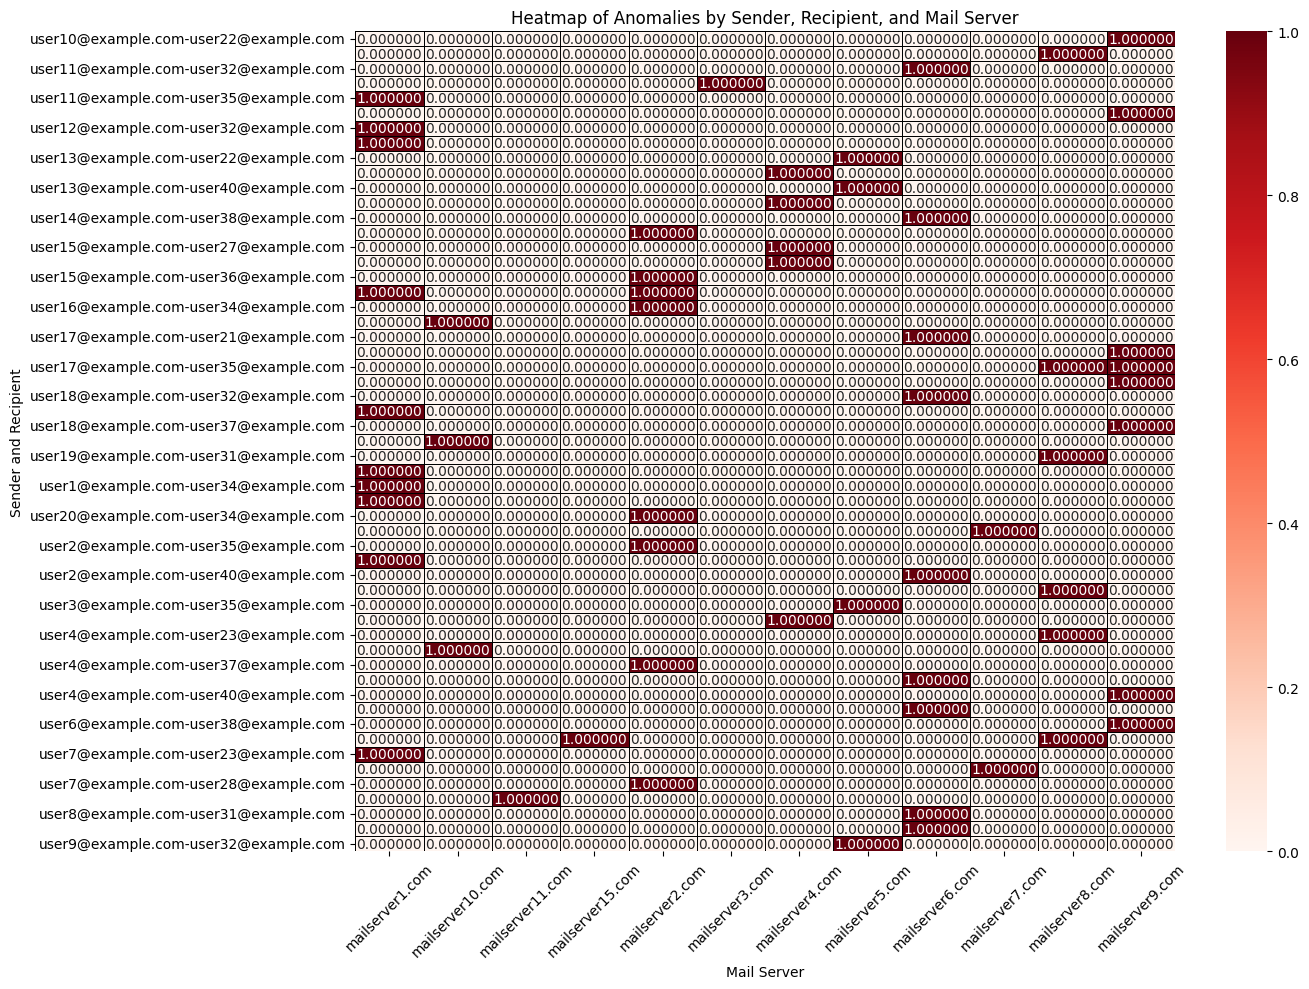

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Seed for reproducibility
np.random.seed(42)

# Generate baseline data
num_baseline_records = 200
timestamps_baseline = pd.date_range(start='2024-01-01', periods=num_baseline_records, freq='H')

# Define more diverse options
log_levels_baseline = ['INFO'] * 160 + ['WARN'] * 30 + ['ERROR'] * 10
senders = [f'user{i}@example.com' for i in range(1, 21)]
recipients = [f'user{i}@example.com' for i in range(21, 41)]
mail_servers = [f'mailserver{i}.com' for i in range(1, 11)]

senders_repeated_baseline = np.random.choice(senders, size=num_baseline_records)
recipients_repeated_baseline = np.random.choice(recipients, size=num_baseline_records)
mail_servers_repeated_baseline = np.random.choice(mail_servers, size=num_baseline_records)

# Create a DataFrame with the baseline data
baseline_df = pd.DataFrame({
    'Timestamp': timestamps_baseline,
    'LogLevel': log_levels_baseline,
    'Sender': senders_repeated_baseline,
    'Recipient': recipients_repeated_baseline,
    'MailServer': mail_servers_repeated_baseline
})

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), ['LogLevel', 'Sender', 'Recipient', 'MailServer'])
    ]
)

# Define the pipeline with preprocessing and Isolation Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('iso_forest', IsolationForest(contamination=0.2, random_state=42))
])

# Fit the pipeline on baseline data
baseline_features = baseline_df[['LogLevel', 'Sender', 'Recipient', 'MailServer']]
pipeline.fit(baseline_features)

# Generate test data with anomalies
num_test_records = 250
test_timestamps = pd.date_range(start='2024-01-01', periods=num_test_records, freq='H')

# Create test data with a mix of normal and anomalous log levels, senders, recipients, and mail servers
test_log_levels = ['INFO'] * 200 + ['ERROR'] * 50

# Add more variety to anomalies
test_senders = [f'user{i}@example.com' for i in range(1, 31)]
test_recipients = [f'user{i}@example.com' for i in range(31, 61)]
test_mail_servers = [f'mailserver{i}.com' for i in range(1, 21)]

test_senders_repeated = np.random.choice(test_senders, size=num_test_records)
test_recipients_repeated = np.random.choice(test_recipients, size=num_test_records)
test_mail_servers_repeated = np.random.choice(test_mail_servers, size=num_test_records)

# Introduce anomalies
anomaly_indices = np.random.choice(num_test_records, size=50, replace=False)
for idx in anomaly_indices:  # Iterate through indices and modify individually
    test_log_levels[idx] = 'ERROR'
test_senders_repeated[anomaly_indices] = np.random.choice(senders, size=50)
test_recipients_repeated[anomaly_indices] = np.random.choice(recipients, size=50)
test_mail_servers_repeated[anomaly_indices] = np.random.choice(mail_servers, size=50)

# Create DataFrame with anomalies
test_df = pd.DataFrame({
    'Timestamp': test_timestamps,
    'LogLevel': test_log_levels,
    'Sender': test_senders_repeated,
    'Recipient': test_recipients_repeated,
    'MailServer': test_mail_servers_repeated
})

# Predict anomalies on the test data
test_features = test_df[['LogLevel', 'Sender', 'Recipient', 'MailServer']]
test_df['Anomaly'] = pipeline.predict(test_features)

# Map the prediction labels to 'Normal' and 'Anomaly'
test_df['Anomaly'] = test_df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Calculate the percentage of successful anomaly detection
anomaly_actual = test_df['LogLevel'] == 'ERROR'
anomaly_predicted = test_df['Anomaly'] == 'Anomaly'

# Success rate is the proportion of correctly predicted anomalies
true_positives = np.sum(anomaly_actual & anomaly_predicted)
total_anomalies = np.sum(anomaly_actual)
success_rate = true_positives / total_anomalies if total_anomalies > 0 else 0

print(f"Percentage of successful anomaly detection: {success_rate * 100:.2f}%")

# Create a DataFrame for heatmap visualization
anomaly_counts = test_df[test_df['Anomaly'] == 'Anomaly'].groupby(['Sender', 'Recipient', 'MailServer']).size().reset_index(name='Count')

# To handle a large number of unique values in the pivot table, you may need to aggregate or filter
if len(anomaly_counts) > 0:
    # Pivot the data for heatmap visualization
    pivot_table = anomaly_counts.pivot_table(
        index=['Sender', 'Recipient'],
        columns='MailServer',
        values='Count',
        fill_value=0
    )

    # Plotting the heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_table, annot=True, fmt='f', cmap='Reds', linewidths=0.5, linecolor='black')

    # Labeling the plot
    plt.title('Heatmap of Anomalies by Sender, Recipient, and Mail Server')
    plt.xlabel('Mail Server')
    plt.ylabel('Sender and Recipient')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit labels

    # Display the plot
    plt.show()
else:
    print("No anomalies detected.")
